In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36011")
client

<Client: 'tcp://127.0.0.1:36011' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/NA-wavelets/'
diag = '/tank/spectre/tuchida/diagnostics/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -19.8
yNstart = 10
yend = 50

tchunk = 1
xchunk = 200
ychunk = 200

ntheta = 36
xo = 50e3

In [6]:
dnf = 2160
nfile = 73
years = np.arange(1963,2013,dtype=int)
ntimes = (np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile) 
          - dnf)
dd = 63
yystart = 4
ntimes[yystart,dd:][::3]

array([1555200, 1561680, 1568160, 1574640])

In [7]:
critt = .7

# DE spectral transfer

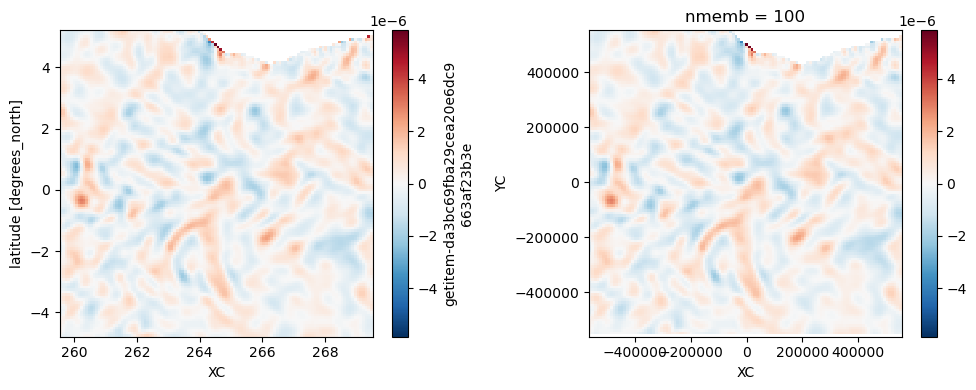

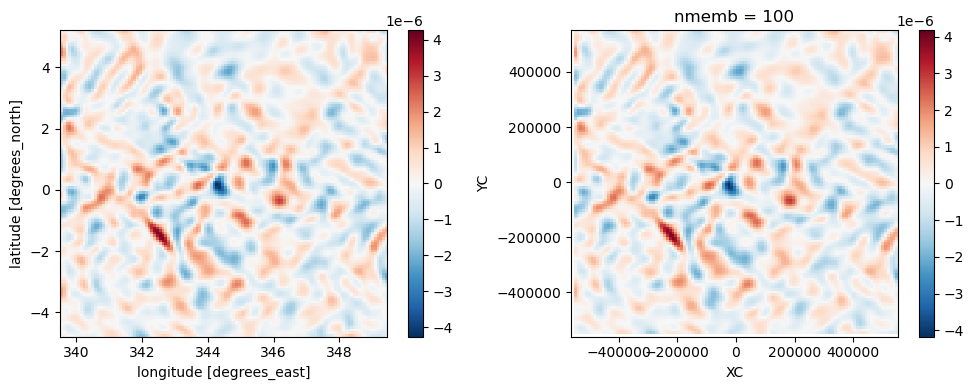

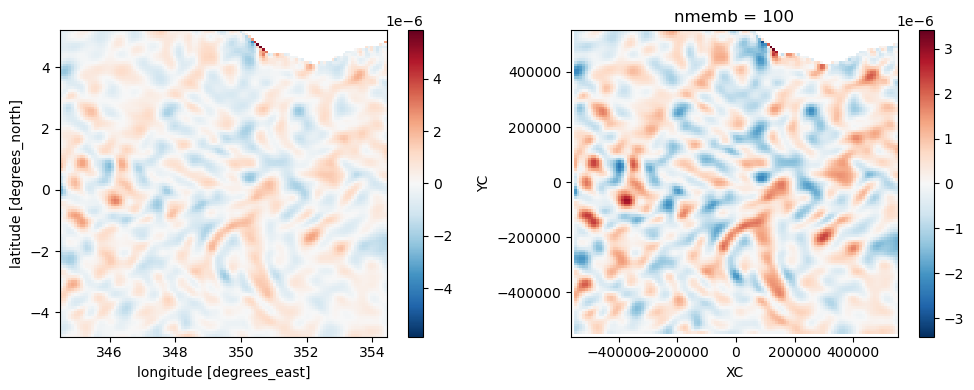

1555200


In [11]:
ystart = ySstart
nmembs = np.arange(100,148)
Zs = [18]

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+3]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes[::3]:
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime
                             ).isel(time=0,
                                    # Z=slice(17,19),
                                    # Zl=slice(17,19),
                                    # Zu=slice(17,19),
                                    # Zp1=slice(17,20)
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        "Z": {"center": "Z",  "outer": "Zp1", 
              "left"  : "Zl", "right": "Zu"
             }
        }
        grid = Grid(dsm, periodic=['X'],
                    coords=coords)
        
        dsh = xr.open_zarr(op.join(savedir,'%4d/%010d/DynEnthalpy.zarr' 
                                   % (years[yystart],itime)))
        dsH = xr.open_zarr(op.join(savedir,'%4d/ensm/%010d/DynEnthalpy.zarr' 
                                   % (years[yystart],itime)))
        
        h_dagger = dsh.h - dsH.H
        
        dsH_ = xr.open_zarr(op.join(savedir,'%4d/%010d/H_ts.zarr' 
                                    % (years[yystart],itime)))
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime
                                    ).isel(time=0,
                                           # Z=slice(17,19),
                                           # Zl=slice(17,19),
                                           # Zu=slice(17,19),
                                           # Zp1=slice(17,20)
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})

            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime          
                                                   ).isel(time=0, 
                                                          # Z=slice(17,19),
                                                          # Zl=slice(17,19),
                                                          # Zu=slice(17,19),
                                                          # Zp1=slice(17,20)
                                                         ).chunk({'YC':ychunk,
                                                                  'YG':ychunk,
                                                                  'XC':xchunk,
                                                                  'XG':xchunk})
                               ], 'nmemb')
        
        ds.coords['nmemb'] = nmembs
        dse = ds - dsm

###########################
        h_x = grid.interp(grid.diff(h_dagger,'X') / ds.dxC,'X'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        h_y = grid.interp(grid.diff(h_dagger,'Y',boundary='extend') / ds.dyC,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        h_z = grid.interp(-grid.diff(h_dagger.chunk({'Z':-1}),'Z',
                                     boundary='extend') 
                          / xr.DataArray(data=ds.drC.isel(Zp1=slice(None,-1)),
                                         dims=['Zl'], coords={'Zl':dsm.Zl}),
                          'Z',boundary='extend'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        t_x = grid.interp(grid.diff(dse.THETA,'X') / ds.dxC,'X'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        t_y = grid.interp(grid.diff(dse.THETA,'Y',boundary='extend') / ds.dyC,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        t_z = grid.interp(-grid.diff(dse.THETA.chunk({'Z':-1}),'Z',
                                     boundary='extend') 
                          / xr.DataArray(data=ds.drC.isel(Zp1=slice(None,-1)),
                                         dims=['Zl'], coords={'Zl':dsm.Zl}),
                          'Z',boundary='extend'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        s_x = grid.interp(grid.diff(dse.SALT,'X') / ds.dxC,'X'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        s_y = grid.interp(grid.diff(dse.SALT,'Y',boundary='extend') / ds.dyC,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        s_z = grid.interp(-grid.diff(dse.SALT.chunk({'Z':-1}),'Z',
                                     boundary='extend') 
                          / xr.DataArray(data=ds.drC.isel(Zp1=slice(None,-1)),
                                         dims=['Zl'], coords={'Zl':dsm.Zl}),
                          'Z',boundary='extend'
                         ).where(ds.maskC!=0.).isel(Z=Zs[0])
        Ht_x = t_x * dsH_.Ht.isel(Z=Zs[0])
        Ht_y = t_y * dsH_.Ht.isel(Z=Zs[0])
        Ht_z = t_z * dsH_.Ht.isel(Z=Zs[0])
        Hs_x = s_x * dsH_.Hs.isel(Z=Zs[0])
        Hs_y = s_y * dsH_.Hs.isel(Z=Zs[0])
        Hs_z = s_z * dsH_.Hs.isel(Z=Zs[0])
###########################
        UV = grid.interp(dse.UVEL,'X').where(ds.maskC!=0.).isel(Z=Zs[0])
        VV = grid.interp(dse.VVEL,'Y',boundary='extend'
                        ).where(ds.maskC!=0.).isel(Z=Zs[0])
        WV = grid.interp(dse.WVEL,'Z',boundary='extend'
                        ).where(ds.maskC!=0.).isel(Z=Zs[0])
        XT = grid.cumsum(ds.dxC,'X')
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        area = ds.rA.where(ds.maskC.isel(Z=Zs[0])!=0.
                          ).reset_coords(drop=True)
        
        if itime == mtimes[0]:
            lat_range = np.arange(ystart,yend+5,5)[3:4]
        else:
            lat_range = np.arange(ystart,yend+5,5)[:-1]
        for lat in lat_range:
            HX = h_x.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            HY = h_y.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            HZ = h_z.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            TX = Ht_x.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            TY = Ht_y.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            TZ = Ht_z.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            SX = Hs_x.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            SY = Hs_y.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            SZ = Hs_z.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            HX = HX.where(np.isfinite(HX)
                         )
            HY = HY.where(np.isfinite(HY)
                         )
            HZ = HZ.where(np.isfinite(HZ)
                         )
            TX = TX.where(np.isfinite(TX)
                         )
            TY = TY.where(np.isfinite(TY)
                         )
            TZ = TZ.where(np.isfinite(TZ)
                         )
            SX = SX.where(np.isfinite(SX)
                         )
            SY = SY.where(np.isfinite(SY)
                         )
            SZ = SZ.where(np.isfinite(SZ)
                         )
            U = UV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            V = VV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            W = WV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = dse.maskC.isel(Z=Zs[0]).sel(YC=slice(lat,lat+10)
                                              ).reset_coords(drop=True)
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):        
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(lon,
                                                                   lon+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum()/np.array(mmm.shape).prod() > critt:
                        hdx  = HX.sel(XC=slice(None,xend))
                        hdy  = HY.sel(XC=slice(None,xend))
                        hdz  = HZ.sel(XC=slice(None,xend))
                        htx  = TX.sel(XC=slice(None,xend))
                        hty  = TY.sel(XC=slice(None,xend))
                        htz  = TZ.sel(XC=slice(None,xend))
                        hsx  = SX.sel(XC=slice(None,xend))
                        hsy  = SY.sel(XC=slice(None,xend))
                        hsz  = SZ.sel(XC=slice(None,xend))
                        u  = U.sel(XC=slice(None,xend))
                        v  = V.sel(XC=slice(None,xend))
                        w  = W.sel(XC=slice(None,xend))
                        x  = X.sel(XC=slice(None,xend))
                        y  = Y.sel(XC=slice(None,xend))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        a   = area.sel(YC=slice(lat,lat+10),
                                       XC=slice(None,xend)
                                      )
                        hhdx  = HX.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhdy  = HY.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhdz  = HZ.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhtx  = TX.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhty  = TY.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhtz  = TZ.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhsx  = SX.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhsy  = SY.sel(XC=slice(dsm.XC.max()-dlon,None))
                        hhsz  = SZ.sel(XC=slice(dsm.XC.max()-dlon,None))
                        uu  = U.sel(XC=slice(dsm.XC.max()-dlon,None))
                        vv  = V.sel(XC=slice(dsm.XC.max()-dlon,None))
                        ww  = W.sel(XC=slice(dsm.XC.max()-dlon,None))
                        xx  = (X.sel(XC=slice(dsm.XC.max()-dlon,None))
                               - X.sel(XC=slice(dsm.XC.max()-dlon,None)).isel(XC=0))
                        x = x + xx.isel(XC=-1)
                        # x.plot()
                        # plt.show()
                        yy  = Y.sel(XC=slice(dsm.XC.max()-dlon,None))
                        aa  = area.sel(YC=slice(lat,lat+10),
                                       XC=slice(dsm.XC.max()-dlon,None)
                                      )
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                          ).reset_coords(drop=True)
                        hdddx = xr.concat([xr.DataArray(hhdx.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hdx
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        hdddy = xr.concat([xr.DataArray(hhdy.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hdy
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        hdddz = xr.concat([xr.DataArray(hhdz.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hdz
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        htttx = xr.concat([xr.DataArray(hhtx.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         htx
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        httty = xr.concat([xr.DataArray(hhty.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hty
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        htttz = xr.concat([xr.DataArray(hhtz.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         htz
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        hsssx = xr.concat([xr.DataArray(hhsx.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hsx
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        hsssy = xr.concat([xr.DataArray(hhsy.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hsy
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        hsssz = xr.concat([xr.DataArray(hhsz.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         hsz
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        uuu = xr.concat([xr.DataArray(uu.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         u
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        vvv = xr.concat([xr.DataArray(vv.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         v
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        www = xr.concat([xr.DataArray(ww.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         w
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, 
                                                     dims=['YC','XC'],
                                             coords={'YC':X.YC,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(xx.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, 
                                                     dims=['YC','XC'],
                                             coords={'YC':Y.YC,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(yy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, 
                                                    dims=['YC','XC'],
                                            coords={'YC':a.YC,
                                                    'XC':np.linspace(lon,
                                                                     lon+dlon,
                                                                     num=len(aa.XC)+1,
                                                                     endpoint=False
                                                                    )[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, 
                                                     dims=['YC','XG'],
                                             coords={'YC':ddx.YC,
                                                     'XG':np.linspace(dsm.XG.min()-dlon,
                                                                      dsm.XG.min(),
                                                                      num=len(dddx.XG)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, 
                                                     dims=['YG','XC'],
                                             coords={'YG':ddy.YG,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(dddy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        HXterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        HYterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        HZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TXterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TYterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SXterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SYterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Wterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            HXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddx.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            HYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddy.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            HZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddz.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            TXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (htttx.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            TYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (httty.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            TZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (htttz.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            SXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssx.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            SYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssy.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            SZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssz.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Wterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (www.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T

                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        HXterp = HXterp / Aterp
                        HYterp = HYterp / Aterp
                        HZterp = HZterp / Aterp
                        TXterp = TXterp / Aterp
                        TYterp = TYterp / Aterp
                        TZterp = TZterp / Aterp
                        SXterp = SXterp / Aterp
                        SYterp = SYterp / Aterp
                        SZterp = SZterp / Aterp
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        Wterp  = Wterp / Aterp
                        # if itime == mtimes[0]:
                        fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, 
                                                      ncols=2)
                        fig.set_tight_layout(True)
                        hdddx.isel(nmemb=0).plot(ax=ax1, rasterized=True)
                        HXterp.isel(nmemb=0).plot(ax=ax2, rasterized=True)
                        plt.show()
                            
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                              coords={'YC':m.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(mm.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        hdx = HX.sel(XC=slice(lon,None))
                        hdy = HY.sel(XC=slice(lon,None))
                        hdz = HZ.sel(XC=slice(lon,None))
                        htx = TX.sel(XC=slice(lon,None))
                        hty = TY.sel(XC=slice(lon,None))
                        htz = TZ.sel(XC=slice(lon,None))
                        hsx = SX.sel(XC=slice(lon,None))
                        hsy = SY.sel(XC=slice(lon,None))
                        hsz = SZ.sel(XC=slice(lon,None))
                        u = U.sel(XC=slice(lon,None))
                        v = V.sel(XC=slice(lon,None))
                        w = W.sel(XC=slice(lon,None))
                        x = X.sel(XC=slice(lon,None))
                        y = Y.sel(XC=slice(lon,None))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                         ).reset_coords(drop=True)
                        a = area.sel(YC=slice(lat,lat+10),
                                     XC=slice(lon,None)
                                    )
                        hhdx = HX.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhdy = HY.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhdz = HZ.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhtx = TX.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhty = TY.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhtz = TZ.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhsx = SX.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhsy = SY.sel(XC=slice(None,dsm.XC.min()+dlon))
                        hhsz = SZ.sel(XC=slice(None,dsm.XC.min()+dlon))
                        uu = U.sel(XC=slice(None,dsm.XC.min()+dlon))
                        vv = V.sel(XC=slice(None,dsm.XC.min()+dlon))
                        ww = W.sel(XC=slice(None,dsm.XC.min()+dlon))
                        xx = X.sel(XC=slice(None,dsm.XC.min()+dlon))+X.isel(XC=-1)
                        yy = Y.sel(XC=slice(None,dsm.XC.min()+dlon))
                        aa = area.sel(YC=slice(lat,lat+10),
                                      XC=slice(None,dsm.XC.min()+dlon)
                                     )
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),
                                           XG=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),
                                           XC=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        hdddx = xr.concat([hdx,
                                         xr.DataArray(hhdx.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        hdddy = xr.concat([hdy,
                                         xr.DataArray(hhdy.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        hdddz = xr.concat([hdz,
                                         xr.DataArray(hhdz.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        htttx = xr.concat([htx,
                                         xr.DataArray(hhtx.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        httty = xr.concat([hty,
                                         xr.DataArray(hhty.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        htttz = xr.concat([htz,
                                         xr.DataArray(hhtz.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        hsssx = xr.concat([hsx,
                                         xr.DataArray(hhsx.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        hsssy = xr.concat([hsy,
                                         xr.DataArray(hhsy.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        hsssz = xr.concat([hsz,
                                         xr.DataArray(hhsz.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        uuu = xr.concat([u,
                                         xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        vvv = xr.concat([v,
                                         xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        www = xr.concat([w,
                                         xr.DataArray(ww.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                             coords={'YC':X.YC,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(xx.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                             coords={'YC':Y.YC,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(yy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                            coords={'YC':a.YC,
                                                    'XC':np.linspace(dsm.XC.max(),
                                                                     dsm.XC.max()+dlon,
                                                                     num=len(aa.XC)+1,
                                                                     endpoint=False
                                                                    )[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                             coords={'YC':ddx.YC,
                                                     'XG':np.linspace(dsm.XG.max(),
                                                                      dsm.XG.max()+dlon,
                                                                      num=len(dddx.XG)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                             coords={'YG':ddy.YG,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(dddy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        HXterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        HYterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        HZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TXterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TYterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SXterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SYterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Wterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            HXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddx.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            HYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddy.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            HZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddz.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            TXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (htttx.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            TYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (httty.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            TZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (htttz.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            SXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssx.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            SYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssy.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            SZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssz.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Wterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (www.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        HXterp = HXterp / Aterp
                        HYterp = HYterp / Aterp
                        HZterp = HZterp / Aterp
                        TXterp = TXterp / Aterp
                        TYterp = TYterp / Aterp
                        TZterp = TZterp / Aterp
                        SXterp = SXterp / Aterp
                        SYterp = SYterp / Aterp
                        SZterp = SZterp / Aterp
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        Wterp  = Wterp / Aterp
                        # if itime == mtimes[dd]:
                        fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, 
                                                      ncols=2)
                        fig.set_tight_layout(True)
                        hdddx.isel(nmemb=0).plot(ax=ax1, rasterized=True)
                        HXterp.isel(nmemb=0).plot(ax=ax2, rasterized=True)
                        plt.show()
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        hdddx = HX.sel(XC=slice(lon,xend))
                        hdddy = HY.sel(XC=slice(lon,xend))
                        hdddz = HZ.sel(XC=slice(lon,xend))
                        htttx = TX.sel(XC=slice(lon,xend))
                        httty = TY.sel(XC=slice(lon,xend))
                        htttz = TZ.sel(XC=slice(lon,xend))
                        hsssx = SX.sel(XC=slice(lon,xend))
                        hsssy = SY.sel(XC=slice(lon,xend))
                        hsssz = SZ.sel(XC=slice(lon,xend))
                        uuu = U.sel(XC=slice(lon,xend))
                        vvv = V.sel(XC=slice(lon,xend))
                        www = W.sel(XC=slice(lon,xend))
                        xT = X.sel(XC=slice(lon,xend))
                        yT = Y.sel(XC=slice(lon,xend))
                        A = area.sel(YC=slice(lat,lat+10),
                                     XC=slice(lon,xend))
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                       ).min().values
                        dy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                       ).min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        HXterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        HYterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        HZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TXterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TYterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        TZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SXterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SYterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        SZterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Wterp = xr.DataArray(np.zeros_like(www), dims=www.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            HXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddx*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            HYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddy*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            HZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hdddz*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            TXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (htttx*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            TYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (httty*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            TZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (htttz*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            SXterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssx*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            SYterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssy*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            SZterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (hsssz*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Wterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (www*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        HXterp = HXterp / Aterp
                        HYterp = HYterp / Aterp
                        HZterp = HZterp / Aterp
                        TXterp = TXterp / Aterp
                        TYterp = TYterp / Aterp
                        TZterp = TZterp / Aterp
                        SXterp = SXterp / Aterp
                        SYterp = SYterp / Aterp
                        SZterp = SZterp / Aterp
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        Wterp  = Wterp / Aterp
                        if lon == dsm.XC.min():
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), 
                                                          nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            hdddy.isel(nmemb=0).plot(ax=ax1, rasterized=True)
                            HYterp.isel(nmemb=0).plot(ax=ax2, rasterized=True)
                            plt.show()
                
                
                if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                    iso_csUf = xrft.isotropic_power_spectrum(
                                Uterp.interpolate_na(dim='XC'
                                                    ).interpolate_na(dim='YC').fillna(0.),
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, 
                                truncate=True
                    )
                    # iso_csUf = xrft.isotropic_cross_spectrum(
                                # Uterp.interpolate_na(dim='XC'
                                #                     ).interpolate_na(dim='YC'
                                #                                     ).fillna(0.), 
                                # AUterp.interpolate_na(dim='XC'
                                #                      ).interpolate_na(dim='YC'
                                #                                      ).fillna(0.), 
                    #             dim=["YC", "XC"], window='hann', 
                    #         window_correction=True, true_amplitude=True, truncate=True
                    # ) 
                    # iso_csVf = xrft.isotropic_cross_spectrum(
                    #             Vterp.interpolate_na(dim='YC'
                    #                                 ).interpolate_na(dim='XC'
                    #                                                 ).fillna(0.), 
                    #             AVterp.interpolate_na(dim='YC'
                    #                                  ).interpolate_na(dim='XC'
                    #                                                  ).fillna(0.), 
                    #             dim=["YC", "XC"], window='hann', 
                    #         window_correction=True, true_amplitude=True, truncate=True
                    # )
                    # if itime == mtimes[0] and lon == dsm.XC.min():
                    #     fig, ax = plt.subplots()
                    #     ax.plot(iso_csUf.freq_r*1e3, 
                    #             -.5*(iso_csUf + iso_csVf).mean('nmemb'))
                    #     ax.set_xscale('log')
                    #     plt.show()
                    # dsave = iso_csUf.to_dataset(name='U')
                    # dsave['V'] = iso_csVf
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    # if la < 0.:
                    #     fname = (
                    #   'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                    #              % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    # else:
                    #     fname = (
                    #   'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                    #              % (itime,np.floor(la),np.floor(lo)))
                    # dsave.attrs['Lat'] = la
                    # dsave.attrs['Lon'] = lo
                    # dsave.to_zarr(op.join(spec,fname), mode='w')
                    # dsave.close()

                    ss = xr.DataArray(np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                  iso_csUf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                              coords={'scale':np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                          iso_csUf.freq_r[0].data**-1,40
                                                         )/xo}
                    )
                    ssf = xr.DataArray(iso_csUf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_csUf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), HXterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), HYterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    iso_csWw = xwavelet.wvlt_cross_spectrum(
                                    Wterp.chunk({'nmemb':1}), HZterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave['W'] = iso_csWw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, iso_csWw, HXterp, HYterp, HZterp
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), TXterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), TYterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    iso_csWw = xwavelet.wvlt_cross_spectrum(
                                    Wterp.chunk({'nmemb':1}), TZterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave['W'] = iso_csWw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, iso_csWw, TXterp, TYterp, TZterp
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), SXterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), SYterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    iso_csWw = xwavelet.wvlt_cross_spectrum(
                                    Wterp.chunk({'nmemb':1}), SZterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave['W'] = iso_csWw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, iso_csWw, SXterp, SYterp, SZterp
                    del Uterp, Vterp
        dse.close()
        dsm.close()
        ds.close()
        dsh.close()
        dsH.close()
        dsH_.close()
        
        print(itime)
    yys += 1

In [16]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})
coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "Z" ,     "outer": "Zp1", 
              "left"  : "Zl",     "right": "Zu"}
        }
grid = Grid(dsm, periodic=['X'],
            coords=coords)
Hktran = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Stktran = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Ssktran = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Hktran_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Stktran_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Ssktran_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
length = 400e3

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,:1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:       
        iy = 0
        for lat in np.arange(ystart,yend+5,5):
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)
                                           ).reset_coords(drop=True)
            ix = 0
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(lon,
                                                                   lon+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        ds2_trans = xr.open_zarr(op.join(spec,fname2))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                       coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                           + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Tk = (ds1_trans.U + ds1_trans.V + ds1_trans.W)
                        Sk = (ds2_trans.U + ds2_trans.V + ds2_trans.W)
                        Hk = (ds0_trans.U + ds0_trans.V + ds0_trans.W)

                        sk = (Sk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        tk = (Tk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        hk = (Hk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        if crit == 1.:
                            Ssktran_full[dict(YC=iy,XC=ix)] = sk.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Stktran_full[dict(YC=iy,XC=ix)] = tk.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Hktran_full[dict(YC=iy,XC=ix)] = hk.sel(scale=length, 
                                                                    method='nearest'
                                                           )   
                        else:
                            Ssktran[dict(YC=iy,XC=ix)] = sk.sel(scale=length, method='nearest'
                                                           )   
                            Stktran[dict(YC=iy,XC=ix)] = tk.sel(scale=length, method='nearest'
                                                           )   
                            Hktran[dict(YC=iy,XC=ix)] = hk.sel(scale=length, method='nearest'
                                                           )   
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(dsm.XC.max(),
                                                                   dsm.XC.max()+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        ds2_trans = xr.open_zarr(op.join(spec,fname2))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                       coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                           + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Tk = (ds1_trans.U + ds1_trans.V + ds1_trans.W)
                        Sk = (ds2_trans.U + ds2_trans.V + ds2_trans.W)
                        Hk = (ds0_trans.U + ds0_trans.V + ds0_trans.W)

                        sk = (Sk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        tk = (Tk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        hk = (Hk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        if crit == 1.:
                            Ssktran_full[dict(YC=iy,XC=ix)] = sk.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Stktran_full[dict(YC=iy,XC=ix)] = tk.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Hktran_full[dict(YC=iy,XC=ix)] = hk.sel(scale=length, 
                                                                    method='nearest'
                                                           )   
                        else:
                            Ssktran[dict(YC=iy,XC=ix)] = sk.sel(scale=length, method='nearest'
                                                           )   
                            Stktran[dict(YC=iy,XC=ix)] = tk.sel(scale=length, method='nearest'
                                                           )   
                            Hktran[dict(YC=iy,XC=ix)] = hk.sel(scale=length, method='nearest'
                                                           )   
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        ds2_trans = xr.open_zarr(op.join(spec,fname2))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                           coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                               + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Tk = (ds1_trans.U + ds1_trans.V + ds1_trans.W)
                        Sk = (ds2_trans.U + ds2_trans.V + ds2_trans.W)
                        Hk = (ds0_trans.U + ds0_trans.V + ds0_trans.W)

                        sk = (Sk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        tk = (Tk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        hk = (Hk.sum('angle') 
                              * np.diff(ds0_trans.angle)[0]*2
                             ).mean('nmemb')
                        if crit == 1.:
                            Ssktran_full[dict(YC=iy,XC=ix)] = sk.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Stktran_full[dict(YC=iy,XC=ix)] = tk.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Hktran_full[dict(YC=iy,XC=ix)] = hk.sel(scale=length, 
                                                                    method='nearest'
                                                           )   
                        else:
                            Ssktran[dict(YC=iy,XC=ix)] = sk.sel(scale=length, method='nearest'
                                                           )   
                            Stktran[dict(YC=iy,XC=ix)] = tk.sel(scale=length, method='nearest'
                                                           )   
                            Hktran[dict(YC=iy,XC=ix)] = hk.sel(scale=length, method='nearest'
                                                           )   
                
                ds0_trans.close()
                ds1_trans.close()
                ds2_trans.close()
                ix += 1
            iy += 1

        dsm.close()
        print(itime)
    yys += 1

# KEflux[dict(XC=0)] = KEflux.isel(XC=-1)
Hktran

1419120


<xarray.DataArray (YC: 15, XC: 18)>
array([[-5.18730594e-04, -1.68574870e-04,  5.33969352e-05,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
         3.90329749e-04,             nan,             nan,
                    nan,             nan, -4.38815928e-04],
       [ 2.52755670e-05, -6.71832123e-05, -3.02033247e-04,
        -2.38977667e-04,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -1.20640179e-03,             nan,
                    nan,  1.13487555e-04,  5.45512075e-05],
       [-2.41951479e-04,  1.43686135e-04, -3.05880686e-04,
        -8.46388471e-05,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -8.16831879e-04,             nan,
                    nan,  1.23160058e-04, -1.24132089e-04],
       [ 2.52503058e-04,  1.90033703e-04, -5.75044487e-04,
         1.95844084e-04,             nan,             nan,
...
         1.07661200e-02,  4.01821493e-03,  8.73492881e-04,
         6.78109261e-04, -1.30562568e-03,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -6.78767003e-03, -1.75656838e-02,
                    nan,             nan,             nan,
                    nan,  2.90378054e-04, -8.27581762e-04],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -7.11384763e-04, -2.07117671e-03,
                    nan,             nan,             nan,
                    nan,  4.12885769e-03,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -2.59008991e-04,             nan,
                    nan,             nan,             nan,
                    nan,  6.19029026e-05,             nan]])
Coordinates:
  * YC       (YC) float64 -14.8 -9.8 -4.8 0.2 5.2 ... 35.2 40.2 45.2 50.2 55.2
  * XC       (XC) float64 264.5 269.5 274.5 279.5 ... 334.5 339.5 344.5 349.5

In [13]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})
coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "Z" ,     "outer": "Zp1", 
              "left"  : "Zl",     "right": "Zu"}
        }
grid = Grid(dsm, periodic=['X'],
            coords=coords
           )
Hkflux = xr.DataArray(np.ones((25, len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['time','YC','XC'], 
                      coords={'time':range(25),
                              'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Stkflux = xr.DataArray(np.ones((25, len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['time','YC','XC'], 
                      coords={'time':range(25),
                              'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Sskflux = xr.DataArray(np.ones((25, len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['time','YC','XC'], 
                      coords={'time':range(25),
                              'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Hkflux_full = xr.DataArray(np.ones((25, len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['time','YC','XC'], 
                      coords={'time':range(25),
                              'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Stkflux_full = xr.DataArray(np.ones((25, len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['time','YC','XC'], 
                      coords={'time':range(25),
                              'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Sskflux_full = xr.DataArray(np.ones((25, len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['time','YC','XC'], 
                      coords={'time':range(25),
                              'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
length = 400e3

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys]
    else:
        mtimes = ntimes[yys]
    
    im = 0
    for itime in mtimes[::3]:       
        iy = 0
        for lat in np.arange(ystart,yend+5,5)[:-1]:
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)
                                           ).reset_coords(drop=True)
            ix = 0
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(lon,
                                                                   lon+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        ds2_trans = xr.open_zarr(op.join(spec,fname2))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                       coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                           + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Tk = (ds1_trans.U + ds1_trans.V + ds1_trans.W)
                        Sk = (ds2_trans.U + ds2_trans.V + ds2_trans.W)
                        Hk = (ds0_trans.U + ds0_trans.V + ds0_trans.W)
                        
                        pis = ((Sk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds2_trans.angle)[0]*2
                              ).mean('nmemb')
                        pit = ((Tk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds1_trans.angle)[0]*2
                              ).mean('nmemb')
                        pih = ((Hk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds0_trans.angle)[0]*2
                              ).mean('nmemb')
                        
                        if crit == 1.:
                            Sskflux_full[dict(time=im,YC=iy,XC=ix)] = pis.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Stkflux_full[dict(time=im,YC=iy,XC=ix)] = pit.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Hkflux_full[dict(time=im,YC=iy,XC=ix)] = pih.sel(scale=length, 
                                                                    method='nearest'
                                                           )   
                        else:
                            Sskflux[dict(time=im,YC=iy,XC=ix)] = pis.sel(scale=length, method='nearest'
                                                           )   
                            Stkflux[dict(time=im,YC=iy,XC=ix)] = pit.sel(scale=length, method='nearest'
                                                           )   
                            Hkflux[dict(time=im,YC=iy,XC=ix)] = pih.sel(scale=length, method='nearest'
                                                           )   
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(dsm.XC.max(),
                                                                   dsm.XC.max()+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        ds2_trans = xr.open_zarr(op.join(spec,fname2))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                       coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                           + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Tk = (ds1_trans.U + ds1_trans.V + ds1_trans.W)
                        Sk = (ds2_trans.U + ds2_trans.V + ds2_trans.W)
                        Hk = (ds0_trans.U + ds0_trans.V + ds0_trans.W)

                        pis = ((Sk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds2_trans.angle)[0]*2
                              ).mean('nmemb')
                        pit = ((Tk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds1_trans.angle)[0]*2
                              ).mean('nmemb')
                        pih = ((Hk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds0_trans.angle)[0]*2
                              ).mean('nmemb')

                        if crit == 1.:
                            Sskflux_full[dict(time=im,YC=iy,XC=ix)] = pis.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Stkflux_full[dict(time=im,YC=iy,XC=ix)] = pit.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Hkflux_full[dict(time=im,YC=iy,XC=ix)] = pih.sel(scale=length, 
                                                                    method='nearest'
                                                           )   
                        else:
                            Sskflux[dict(time=im,YC=iy,XC=ix)] = pis.sel(scale=length, method='nearest'
                                                           )   
                            Stkflux[dict(time=im,YC=iy,XC=ix)] = pit.sel(scale=length, method='nearest'
                                                           )   
                            Hkflux[dict(time=im,YC=iy,XC=ix)] = pih.sel(scale=length, method='nearest'
                                                           )   
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Hk/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Theta/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname2 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Sk/Salt/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        ds2_trans = xr.open_zarr(op.join(spec,fname2))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                           coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                               + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Tk = (ds1_trans.U + ds1_trans.V + ds1_trans.W)
                        Sk = (ds2_trans.U + ds2_trans.V + ds2_trans.W)
                        Hk = (ds0_trans.U + ds0_trans.V + ds0_trans.W)

                        pis = ((Sk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds2_trans.angle)[0]*2
                              ).mean('nmemb')
                        pit = ((Tk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds1_trans.angle)[0]*2
                              ).mean('nmemb')
                        pih = ((Hk * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds0_trans.angle)[0]*2
                              ).mean('nmemb')

                        if crit == 1.:
                            Sskflux_full[dict(time=im,YC=iy,XC=ix)] = pis.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Stkflux_full[dict(time=im,YC=iy,XC=ix)] = pit.sel(scale=length, 
                                                                     method='nearest'
                                                           )   
                            Hkflux_full[dict(time=im,YC=iy,XC=ix)] = pih.sel(scale=length, 
                                                                    method='nearest'
                                                           )   
                        else:
                            Sskflux[dict(time=im,YC=iy,XC=ix)] = pis.sel(scale=length, method='nearest'
                                                           )   
                            Stkflux[dict(time=im,YC=iy,XC=ix)] = pit.sel(scale=length, method='nearest'
                                                           )   
                            Hkflux[dict(time=im,YC=iy,XC=ix)] = pih.sel(scale=length, method='nearest'
                                                           )  
                
                ds0_trans.close()
                ds1_trans.close()
                ds2_trans.close()
                ix += 1
            iy += 1

        dsm.close()
        im += 1
        print(itime)
    yys += 1

# KEflux[dict(XC=0)] = KEflux.isel(XC=-1)
Hkflux

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


<xarray.DataArray (time: 25, YC: 15, XC: 18)>
array([[[-7.06171596e-10, -1.52159007e-09,  1.49240093e-10, ...,
                     nan,             nan, -5.66197516e-10],
        [-4.07230088e-10, -6.21600853e-10, -7.63104148e-10, ...,
                     nan, -4.61702950e-10, -6.70218380e-10],
        [-2.62740839e-09, -1.96182435e-09, -3.52609344e-09, ...,
                     nan, -3.75165470e-09, -2.42200632e-09],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,  6.08180563e-09,  2.67790085e-09],
        [            nan,             nan,             nan, ...,
                     nan,  9.16198029e-09,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-6.48758702e-10, -6.08001936e-10,  3.21210093e-11, ...,
                     nan,             nan, -9.51985902e-10],
        [-1.55334363e-09, -5.94423678e-10, -1.62646959e-10, ...,
                     nan, -2.55429955e-10, -1.37820474e-09],
        [-3.26252771e-09, -2.16932192e-09, -1.65881549e-09, ...,
                     nan, -2.66526795e-09, -2.14238018e-09],
...
        [            nan,             nan,             nan, ...,
                     nan,  1.79879148e-08,  1.42238296e-08],
        [            nan,             nan,             nan, ...,
                     nan,  1.17734660e-08,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-9.08040904e-10, -7.08115847e-10,  8.11719503e-10, ...,
                     nan,             nan, -8.77330353e-10],
        [-5.01038986e-10, -1.45166536e-09, -7.43731450e-10, ...,
                     nan, -4.04662859e-10, -6.96209953e-12],
        [-2.23510048e-09, -1.65471618e-09, -2.34494555e-09, ...,
                     nan, -3.54468194e-09, -1.73025424e-09],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,  1.69074717e-08,  1.46629474e-08],
        [            nan,             nan,             nan, ...,
                     nan,  1.19612813e-08,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
  * YC       (YC) float64 -14.8 -9.8 -4.8 0.2 5.2 ... 35.2 40.2 45.2 50.2 55.2
  * XC       (XC) float64 264.5 269.5 274.5 279.5 ... 334.5 339.5 344.5 349.5

## 1967-01-01

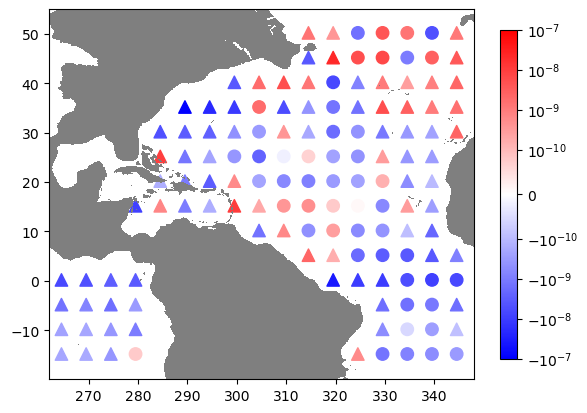

In [22]:
xx, yy = np.meshgrid(Stkflux.XC, Stkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=(Stkflux+Sskflux).isel(time=0,YC=slice(None,-1)), cmap='bwr',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=(Stkflux_full+Sskflux_full).isel(time=0,YC=slice(None,-1)), cmap='bwr',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/SkCum_Z0452_s=%03dkm_%010d_xgcm.pdf' 
                    % (int(length*1e-3), ntimes[0,0])))

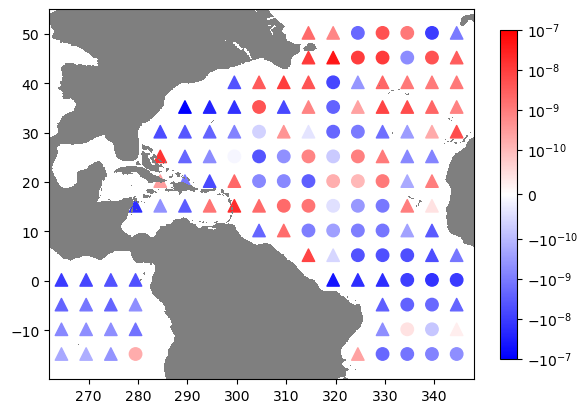

In [23]:
xx, yy = np.meshgrid(Stkflux.XC, Stkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=(Stkflux).isel(time=0,YC=slice(None,-1)), cmap='bwr',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=(Stkflux_full).isel(time=0,YC=slice(None,-1)), cmap='bwr',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/StkCum_Z0452_s=%03dkm_%010d_xgcm.pdf' 
                    % (int(length*1e-3), ntimes[0,0])))

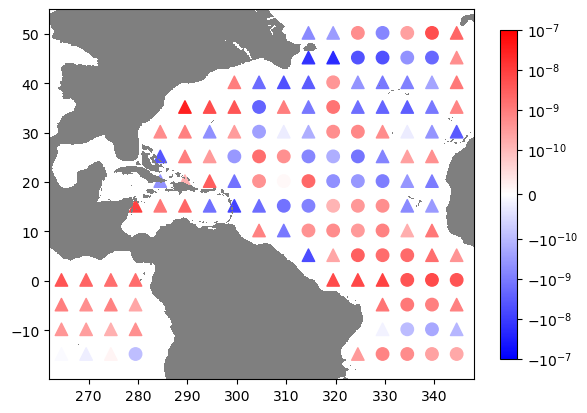

In [24]:
xx, yy = np.meshgrid(Stkflux.XC, Stkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=(Sskflux).isel(time=0,YC=slice(None,-1)), cmap='bwr',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=(Sskflux_full).isel(time=0,YC=slice(None,-1)), cmap='bwr',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/SskCum_Z0452_s=%03dkm_%010d_xgcm.pdf' 
                    % (int(length*1e-3), ntimes[0,0])))

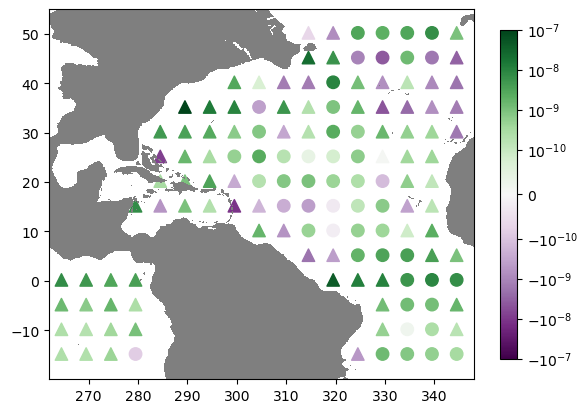

In [25]:
xx, yy = np.meshgrid(Hkflux.XC, Hkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=-Hkflux.isel(time=0,YC=slice(None,-1)), cmap='PRGn',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=-Hkflux_full.isel(time=0,YC=slice(None,-1)), cmap='PRGn',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/HkCum_Z0452_s=%03dkm_%010d_xgcm.pdf' 
                    % (int(length*1e-3), ntimes[0,0])))

## 1967

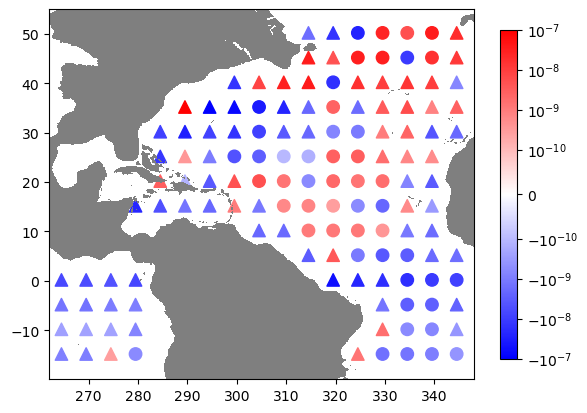

In [14]:
xx, yy = np.meshgrid(Stkflux.XC, Stkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=(Stkflux+Sskflux).isel(YC=slice(None,-1)).mean('time'), cmap='bwr',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=(Stkflux_full+Sskflux_full).isel(YC=slice(None,-1)).mean('time'), cmap='bwr',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/SkCum_Z0452_s=%03dkm_1967_xgcm.pdf' 
                    % (int(length*1e-3))))

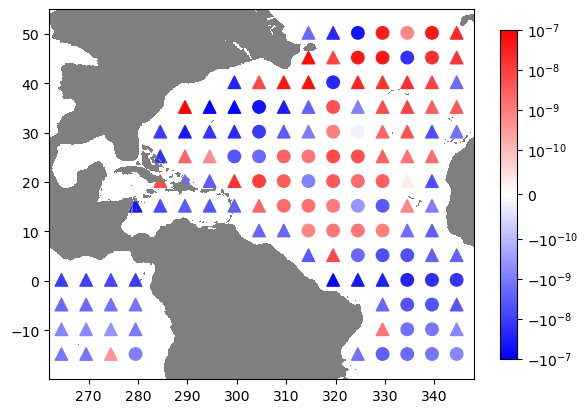

In [15]:
xx, yy = np.meshgrid(Stkflux.XC, Stkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=(Stkflux).isel(YC=slice(None,-1)).mean('time'), cmap='bwr',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=(Stkflux_full).isel(YC=slice(None,-1)).mean('time'), cmap='bwr',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/StkCum_Z0452_s=%03dkm_1967_xgcm.pdf' 
                    % (int(length*1e-3))))

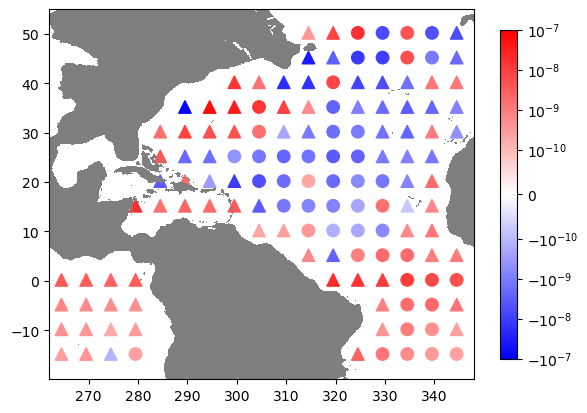

In [16]:
xx, yy = np.meshgrid(Stkflux.XC, Stkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=(Sskflux).isel(YC=slice(None,-1)).mean('time'), cmap='bwr',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=(Sskflux_full).isel(YC=slice(None,-1)).mean('time'), cmap='bwr',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/SskCum_Z0452_s=%03dkm_1967_xgcm.pdf' 
                    % (int(length*1e-3))))

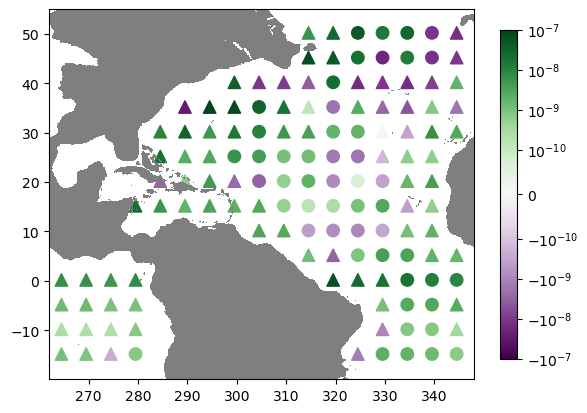

In [17]:
xx, yy = np.meshgrid(Hkflux.XC, Hkflux.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=-Hkflux.isel(YC=slice(None,-1)).mean('time'), cmap='PRGn',
                rasterized=True,
                norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
             )
ax.scatter(xx, yy, 
           s=80,
           c=-Hkflux_full.isel(YC=slice(None,-1)).mean('time'), cmap='PRGn',
           rasterized=True,
           norm=clr.SymLogNorm(linthresh=1e-10, vmin=-1e-7, vmax=1e-7)
          )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/HkCum_Z0452_s=%03dkm_1967_xgcm.pdf' 
                    % (int(length*1e-3))))